In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import pdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

/home/ck/pythonWorkspace/proj_CEH


In [767]:
CP4 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_zeroRain_gt1k_shear_CP4.p', 'rb'))
CP25 = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-50_zeroRain_gt1k_shear_CP25.p', 'rb'))
OBS_PRECIP = pkl.load( open (cnst.CLOVER_SAVES + 'bulk_-40_zeroRain_gt5k_-40thresh_OBSera_thicklayer.p', 'rb'))

In [768]:
print(CP4.keys())

dict_keys(['lat', 'qmean', 'pmax', 'hour', 'clat', 'umax_srfc', 't', 'shear', 'pgt01isvalid', 'u_mid', 'pmean', 'shearmean', 'qmax', 'umean_mid', 'tmin', 'year', 'area', 'q', 'clon', 'shearmin', 'tmean', 'u_srfc', 'month', 'umin_mid', 'lon', 'umean_srfc', 'p', 'pgt30'])


In [769]:
dic = OBS

pp = np.array(dic['pmax'])
sh = np.array(dic['shear']) #np.array(dic['shear']) * (-1)
umin = np.array(dic['u650'])
umax = np.array(dic['u925'])
qq = np.array(dic['q925']) 
tt = np.array(dic['tmin'])
ttm = np.array(dic['tmean'])
month = np.array(dic['month'])
area = np.array(dic['area'])
lat = np.array(dic['clat'])
lon = np.array(dic['clon'])

obs_pcp = {
    'prcp' : pp,
    'u650' : umin,
    'u925' : umax,
    'q925' : qq*1000,
    'shear' : sh*-1,
    'month' : month,
    'area' : area*7.7**2,
    'tmin' : tt,
    'tmean' : ttm,
    'lat' : lat,
    'lon' : lon,
} 
obs = pd.DataFrame(obs_pcp)

In [770]:
dic = CP4

pp = np.array(dic['pmax'])
sh = np.array(dic['shearmin']) #np.array(dic['shear']) * (-1)
umin = np.array(dic['umin_mid'])
umax = np.array(dic['umax_srfc'])
qq = np.array(dic['qmax']) 
tt = np.array(dic['tmin'])
ttm = np.array(dic['tmean'])
month = np.array(dic['month'])
area = np.array(dic['area'])
lat = np.array(dic['clat'])
lon = np.array(dic['clon'])

cp4_dic = {
    'prcp' : pp,
    'u650' : umin,
    'u925' : umax,
    'q925' : qq*1000,
    'shear' : sh*-1,
    'month' : month,
    'area' : area*4.4**2,
    'tmin' : tt,
    'tmean' : ttm,
    'lat' : lat,
    'lon' : lon,
} 
cp4 = pd.DataFrame(cp4_dic)

In [771]:
dic = CP25

pp = np.array(dic['pmax'])
sh = np.array(dic['shearmin']) #np.array(dic['shear']) * (-1)
umin = np.array(dic['umin_mid'])
umax = np.array(dic['umax_srfc'])
qq = np.array(dic['qmax']) 
tt = np.array(dic['tmin'])
ttm = np.array(dic['tmean'])
month = np.array(dic['month'])
area = np.array(dic['area'])
lat = np.array(dic['clat'])
lon = np.array(dic['clon'])

cp25_dic = {
    'prcp' : pp*3600,
    'u650' : umin,
    'u925' : umax,
    'q925' : qq*1000,
    'shear' : sh*-1,
    'month' : month,
    'area' : area*25**2,
    'tmin' : tt,
    'tmean' : ttm,
    'lat' : lat,
    'lon' : lon,
} 
cp25 = pd.DataFrame(cp25_dic)

(array([ 27., 123., 233., 261., 222., 194., 136.,  94.,  52.,  20.]),
 array([-95.25037713, -89.92533941, -84.6003017 , -79.27526399,
        -73.95022628, -68.62518856, -63.30015085, -57.97511314,
        -52.65007543, -47.32503771, -42.        ]),
 <a list of 10 Patch objects>)

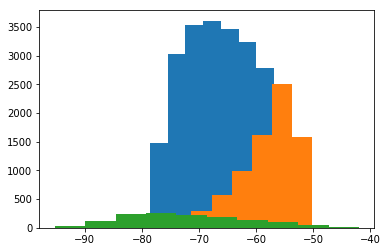

In [772]:
plt.hist(cp4.tmin)
plt.hist(cp25.tmin)
plt.hist(obs.tmin)

(0, 150)

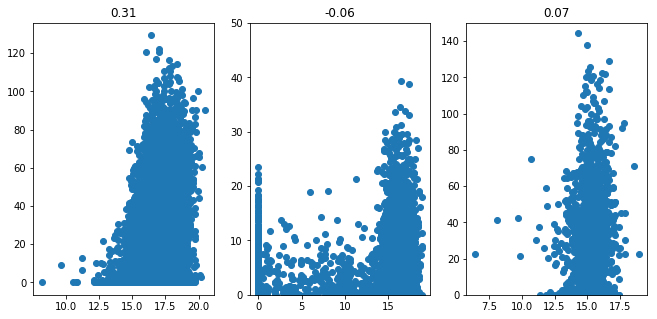

In [776]:
cp4s = [cp4.q925, cp4.prcp]
cp25s = [cp25.q925, cp25.prcp]
obss = [obs.q925, obs.prcp]


f = plt.figure(figsize=(11,5))
ax = f.add_subplot(131)
r = stats.pearsonr(cp4s[0],cp4s[1])
plt.scatter(cp4s[0],cp4s[1])
plt.title(str(np.round(r[0], decimals=2)))

ax = f.add_subplot(132)
plt.scatter(cp25s[0],cp25s[1])
r = stats.pearsonr(cp25s[0],cp25s[1])
plt.title(str(np.round(r[0], decimals=2)))
ax.set_ylim(0,50)

ax = f.add_subplot(133)
plt.scatter(obss[0],obss[1])
r = stats.pearsonr(obss[0],obss[1])
plt.title(str(np.round(r[0], decimals=2)))
ax.set_ylim(0,150)
#ax.set_ylim(13,19)


In [338]:
def get_ERA(era, indic):

    dic = {}
    dic['u925'] = []
    dic['u650'] = []
    dic['q925'] = []
    dic['q700'] = []
    for id, date in enumerate(indic.date):

        getera =np.where((era['time.day']==(indic['date'])[id].day) & (era['time.month']==indic.month[id]) & (era['time.year']==indic.year[id]))

        try:
            era_day = era.isel(time=int(getera[0]))
        except TypeError:
            print('Era missing')
            dic['u925'].append(np.nan)
            dic['u650'].append(np.nan)
            dic['q925'].append(np.nan)
            dic['q700'].append(np.nan)

            continue

        elat = indic.clat[id]
        elon = indic.clon[id]
        dic['u925'].append(float(era_day['u'].sel(latitude=elat, longitude=elon, level=925, method='nearest').values))
        dic['u650'].append(float(era_day['u'].sel(latitude=elat, longitude=elon, level=650, method='nearest').values))
        dic['q925'].append(float(era_day['q'].sel(latitude=elat, longitude=elon, level=925, method='nearest').values))
        dic['q700'].append(float(era_day['q'].sel(latitude=elat, longitude=elon, level=700, method='nearest').values))

    return dic

In [339]:
pdf = pkl.load(open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA.p', 'rb'))
pdf = pdf.where((pdf.clat>=4.5) & (pdf.clat<=8.5) & (pdf.clon>=-12) & (pdf.clon<=12))
pdf = pdf.dropna()

ttg = np.array(pdf.tmin, dtype=float)
ttm = np.array(pdf.tmean, dtype=float)
month = pdf.month.values
area = pdf.area.values
area70 = np.array(pdf['70area'], dtype=int)
lat = pdf.clat.values
lon = pdf.clon.values

In [340]:
#era = xr.open_dataset(cnst.ERA_DAILY_PL12UTC)

In [341]:
#era_out = get_ERA(era, pdf)
#pkl.dump(era_out,open(cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA.p', 'wb'))

In [342]:
era_out = pkl.load( open (cnst.CLOVER_SAVES + 'StormLoc_-50_5000km_WA_ERA.p', 'rb'))

In [343]:
era_out.keys()

dict_keys(['q700', 'q925', 'u650', 'u925'])

In [344]:
e_u650 = np.array(era_out['u650'])
e_u925 = np.array(era_out['u925'])
e_q925 = np.array(era_out['q925'])
e_q700 = np.array(era_out['q700'])

In [345]:
dic = {
    'u650' : e_u650,
    'u925' : e_u925,
    'q925' : e_q925*1000,
    'q700' : e_q700*1000,
    'shear' : (e_u650-e_u925)*-1,
    'month' : month,
    'area' : area*7.7**2,
    'area70' : area70*7.7**2,
    'tmin' : ttg,
    'tmean' : ttm,
    'lat' : lat,
    'lon' : lon,
} 
ds = pd.DataFrame(dic)

In [346]:
ds = ds.dropna()

In [347]:
ds

,area,area70,lat,lon,month,q700,q925,shear,tmean,tmin,u650,u925
39,5573.26,592.90,5.599998,-8.324997,3.0,4.734027,16.598180,5.067841,-61.783619,-71.769989,-5.548030,-0.480189
40,8952.79,0.00,7.000000,-10.144997,3.0,5.601223,16.207278,6.442264,-59.993172,-68.759995,-4.953953,1.488311
41,7944.86,0.00,4.970001,6.654999,3.0,5.845153,15.737448,3.954636,-55.536934,-63.069992,-4.114089,-0.159454
42,20099.31,1245.09,5.285000,-7.415001,3.0,6.248983,14.360277,8.192532,-57.212448,-74.919998,-8.169024,0.023509
43,8004.15,118.58,5.180000,-1.779999,3.0,4.868410,15.805490,8.709456,-59.964134,-70.189987,-8.854582,-0.145125
44,19743.57,3972.43,5.915001,-0.449997,3.0,4.441446,16.107937,7.757169,-63.424614,-73.269989,-8.482043,-0.724874
45,12806.64,59.29,5.915001,-4.755005,3.0,5.430097,15.647972,5.182469,-56.779160,-76.649994,-6.346012,-1.163543
46,12628.77,1067.22,6.790001,-9.200005,3.0,6.521491,15.968790,6.928327,-58.333984,-74.919998,-7.336874,-0.408547
47,31838.73,2430.89,5.495003,-0.625000,3.0,6.655875,14.628363,6.623023,-61.091873,-76.649994,-5.710052,0.912971
48,6284.74,889.35,4.900002,-6.889999,3.0,6.627297,15.620075,6.118222,-61.486126,-74.919998,-6.504726,-0.386504


In [791]:
pos1 = (ds.month<=5)  & (ds.u650<0) & (ds.area>=5000)
pos2 = (ds.month>=9)  & (ds.u650<0) & (ds.area>=5000)

opos1 = (obs.month<=5)  & (obs.u650<0) & (obs.area>=5000)
opos2 = (obs.month>=9)  & (obs.u650<0) & (obs.area>=5000)

cpos1 = (cp4.month<=5)  & (cp4.u650<0) & (cp4.area>=5000) & (cp4.prcp>=0.1)
cpos2 = (cp4.month>=9)  & (cp4.u650<0) & (cp4.area>=5000) & (cp4.prcp>=0.1)

cpos125 = (cp25.month<=5)  & (cp25.u650<0) & (cp25.area>=5000) & (cp25.prcp>0)
cpos225 = (cp25.month>=9)  & (cp25.u650<0) & (cp25.area>=5000) & (cp25.prcp>0)

In [778]:
np.sum(cpos225)

1584

(array([ 695., 3224., 3138., 2362., 1916., 1435., 1149.,  936.,  811.]),
 array([  5000.        ,  15555.55555556,  26111.11111111,  36666.66666667,
         47222.22222222,  57777.77777778,  68333.33333333,  78888.88888889,
         89444.44444444, 100000.        ]),
 <a list of 9 Patch objects>)

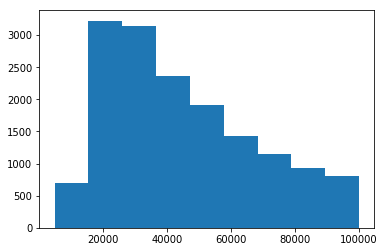

In [779]:
plt.hist(cp4.area, bins=np.linspace(5000,100000,10))

In [792]:
ds_march = ds[pos1]
ds_oct = ds[pos2]
obs_march = obs[opos1]
obs_oct = obs[opos2]
cp4_march = cp4[cpos1]
cp4_oct = cp4[cpos2]
cp25_march = cp25[cpos125]
cp25_oct = cp25[cpos225]

(0, 130)

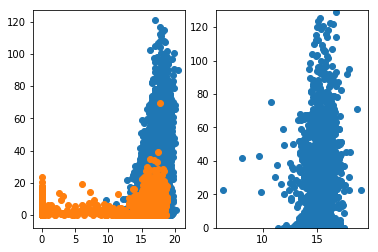

In [803]:
f = plt.figure()
ax = f.add_subplot(121)
plt.scatter(cp4_march.q925, cp4_march.prcp)
plt.scatter(cp25_march.q925, cp25_march.prcp)
ax = f.add_subplot(122)
plt.scatter(obs.q925, obs.prcp)
ax.set_ylim(0,130)

(array([   5.,   18.,  171.,  577., 1482., 2537., 3031., 2376., 1460.,
         696.]),
 array([-2.11736908e+01, -1.90567263e+01, -1.69397619e+01, -1.48227974e+01,
        -1.27058329e+01, -1.05888684e+01, -8.47190396e+00, -6.35493949e+00,
        -4.23797502e+00, -2.12101054e+00, -4.04606992e-03]),
 <a list of 10 Patch objects>)

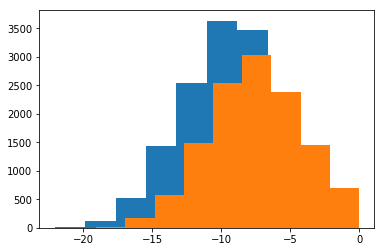

In [559]:
plt.hist(ds_march.u650)
plt.hist(ds_oct.u650)

In [560]:
cp4.lon.max()

12.901748657226562

In [561]:
def density_plot(v1,v2,v3):
    xy = np.vstack([v1, v2])
    z = gaussian_kde(xy)(xy)
    data = z / (z.max() - z.min())

    r = u_stat.pcor(v1,v2,v3)
    print('pears', stats.pearsonr(v1,v2))
    
    return data, r

In [562]:
def plot_scatter_month(dat):
    fig = plt.figure(figsize=(9, 5), dpi=100)
    cc=11
    ax1 = fig.add_subplot(221)

    data1, r1 = density_plot(dat.u650, dat.tmin, dat.q925)

    mappable = ax1.scatter(dat.u650, dat.tmin, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
    ax1.set_ylabel('Min. T')
    ax1.set_xlabel('u925hPa')
    ax1.set_title('P-corr. shear/Tmin | q removed: '+str(np.round(r1[0], decimals=2)), fontsize=cc)
    ax1.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(222)

    data2, r2 = density_plot(dat.q925, dat.tmin, dat.shear)

    mappable = ax2.scatter(dat.q925, dat.tmin, c=data2, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(13, 18)
    ax2.set_ylabel('Min T')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. tt/qq | shear removed: '+str(np.round(r2[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(223)

    data3, r3 = density_plot(dat.q925, dat.shear, dat.u650)

    mappable = ax2.scatter(dat.q925, dat.shear, c=data3, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(13, 18)
    ax2.set_ylabel('shear')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. qq/shear | umax removed: '+str(np.round(r3[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(224)

    data4, r4 = density_plot(dat.u925, dat.tmin, dat.u650)

    mappable = ax2.scatter(dat.u925, dat.tmin , c=data4, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(0, 10)
    ax2.set_ylabel('min T')
    ax2.set_xlabel('qmid')
    ax2.set_title('P-corr. qq700/tmin | u650hPa removed: '+str(np.round(r4[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    plt.tight_layout()



In [563]:
def plot_scatter_month_double(dat, dat2):
    fig = plt.figure(figsize=(9, 5), dpi=100)
    cc=11
    ax1 = fig.add_subplot(221)

    data1, r1 = density_plot(dat.shear, dat.tmin, dat.q925)

    mappable = ax1.scatter(dat.shear, dat.tmin, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
    ax1.set_ylabel('Min. T')
    ax1.set_xlabel('u925hPa')
    ax1.set_title('P-corr. shear/Tmin | q removed: '+str(np.round(r1[0], decimals=2)), fontsize=cc)
    ax1.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(222)

    data2, r2 = density_plot(dat.q925, dat.tmin, dat.shear)

    mappable = ax2.scatter(dat.q925, dat.tmin, c=data2, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(13, 20)
    ax2.set_ylabel('Min T')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. tt/qq | shear removed: '+str(np.round(r2[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax1 = fig.add_subplot(223)

    data1, r1 = density_plot(dat2.shear, dat2.tmin, dat2.q925)

    mappable = ax1.scatter(dat2.shear, dat2.tmin, c=data1, edgecolor='', cmap='viridis_r', s=20) # viridis_r
    ax1.set_ylabel('Min. T')
    ax1.set_xlabel('u925hPa')
    ax1.set_title('P-corr. shear/Tmin | q removed: '+str(np.round(r1[0], decimals=2)), fontsize=cc)
    ax1.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    ####################################################################################
    ax2 = fig.add_subplot(224)

    data2, r2 = density_plot(dat2.q925, dat2.tmin, dat2.shear)

    mappable = ax2.scatter(dat2.q925, dat2.tmin, c=data2, edgecolor='', cmap='viridis_r', s=15) # viridis_r
    ax2.set_xlim(13, 20)
    ax2.set_ylabel('Min T')
    ax2.set_xlabel('max. q925hPa')
    ax2.set_title('P-corr. tt/qq | shear removed: '+str(np.round(r2[0], decimals=2)), fontsize=cc)
    ax2.tick_params(direction='in')
    cbar = fig.colorbar(mappable)
    cbar.set_label('Density')

    plt.tight_layout()

In [564]:
ds_oct.shape

(12353, 12)

pears (0.20502752354022166, 1.5164495676913728e-31)
pears (-0.3162540931386399, 7.625189638489826e-75)
pears (0.4479393471466611, 7.09615356581044e-157)
pears (-0.11553807191195364, 6.286888996995245e-11)


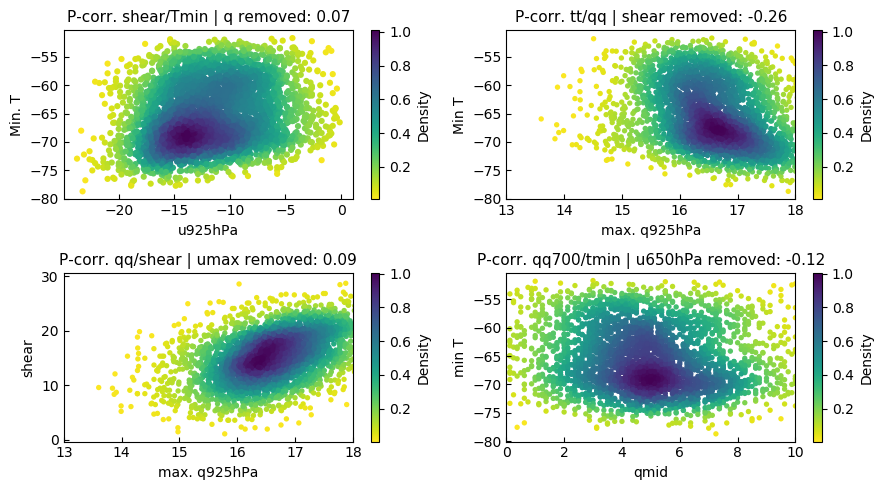

In [565]:
plot_scatter_month(cp4_oct)

pears (-0.18011087643397025, 2.76356653404018e-111)
pears (-0.08921940988879681, 2.592889096401661e-28)
pears (-0.25833940642370673, 6.974584956608225e-73)
pears (-0.32669615022164095, 6.987763990544748e-118)


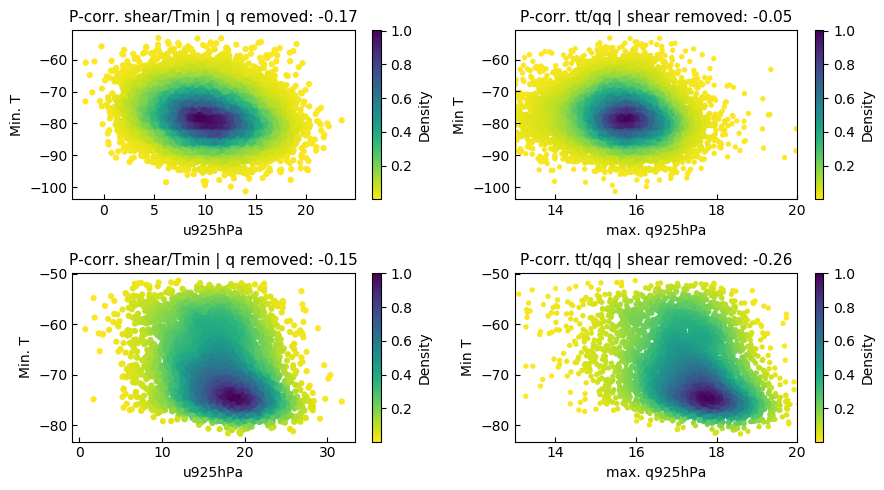

In [566]:
plot_scatter_month_double(ds_march, cp4_march)

pears (-0.1233494698676231, 4.389511677792198e-43)
pears (-0.10137624040214407, 1.3837633911419267e-29)
pears (-0.19888157356216005, 9.570279354613334e-30)
pears (-0.3162540931386399, 7.625189638489826e-75)


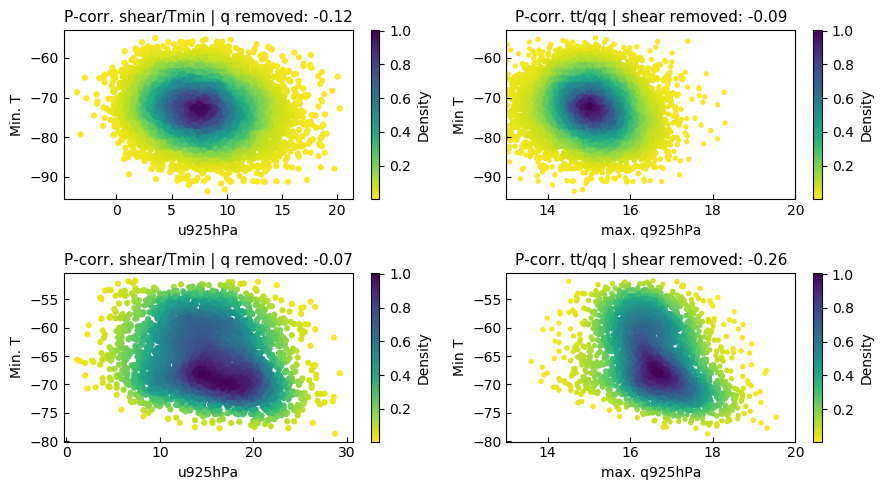

In [567]:
plot_scatter_month_double(ds_oct, cp4_oct)

In [568]:
alln=7
nbs= alln
nbq= alln
nba = alln

shearb_march = np.percentile(ds_march.shear[(ds_march.shear>=3) & (ds_march.shear<=17)], np.linspace(0,100,nbs))
shearb_oct = np.percentile(ds_oct.shear[(ds_oct.shear>=3) & (ds_oct.shear<=17)], np.linspace(0,100,nbs))

shearc_march = np.percentile(cp4_march.shear[(cp4_march.shear>=8) & (cp4_march.shear<=25)], np.linspace(0,100,nbs))
shearc_oct = np.percentile(cp4_oct.shear[(cp4_oct.shear>=8) & (cp4_oct.shear<=25)], np.linspace(0,100,nbs))

abins = np.linspace(5000,250000, nba)
qbinsb_march = np.linspace(13.5,18, nbq)
qbinsb_oct = np.linspace(13.5,18, nbq)
qbinsc_march = np.linspace(15.5,18.5, nbq)
qbinsc_oct = np.linspace(15.5,18.5, nbq)

In [569]:
len(qbins)

9

In [570]:
def create_2dhist(ds, xbins,ybins):
#     sheardiff = shearbins[0:-1]+((xbins[1::]-shearbins[0:-1])/2)[0]
#     qdiff= qbins[0:-1] + ((qbins[1::]-qbins[0:-1])/2)[0]

    outperc_ds = np.zeros((nbs,nbq))
    outval = np.zeros((nbs,nbq))
    outarea_ds = np.zeros((nbs,nbq))

    corrlist = []
    stdlist = []

    for isq, qql in enumerate(ybins[0:-1]):
        for issh, shl in enumerate(xbins[0:-1]):

            poss_ds = (ds.shear >= shl) & (ds.shear < xbins[issh+1]) & (ds.q925>=qql) & (ds.q925 < ybins[isq+1])
          
            try:
                ds_mean = np.percentile(ds.tmean[poss_ds], 5)
            except IndexError:
                ds_mean = np.nan

            try:
                ds_amean = np.percentile(ds.area[poss_ds], 75)
            except IndexError:
                ds_amean = np.nan

            outarea_ds[issh,isq] = ds_amean
            outperc_ds[issh,isq] = ds_mean

            outval[issh,isq] = np.sum(poss_ds)
            
    return outperc_ds, outarea_ds, outval

In [571]:
def hist2d_plot(data,xbins, ybins, vmin, vmax, valid=None):
    f = plt.figure()
    ax5 = f.add_subplot(111)
    X, Y = np.meshgrid(xbins,ybins)
    cmapp = uplot.discrete_cmap(8, base_cmap='RdBu_r')
    if valid is not None:
        data[valid<50] = np.nan
    Zm = ma.masked_where(np.isnan(data),data)

    mappable = ax5.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=vmin, vmax=vmax) # viridis_rvmin=20, vmax=40
    #mappable = ax5.pcolormesh(X, Y, Zm.T, cmap=cmapp) # viridis_rvmin=20, vmax=40

    ax5.set_ylabel('Max. q925hPa')
    ax5.set_xlabel('Max. u925hPa (equally populated)')
    ax5.set_title('')
    cbar = f.colorbar(mappable, ticks=np.linspace(vmin,vmax,9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
    cbar.set_label('90th centile max. rain')
    plt.show()

In [659]:
def hist2d_quatro(data, valid=False):
    f = plt.figure(figsize=(10,7))
    for i, dat in enumerate(data):
        ax = f.add_subplot(2,2,i+1)
      
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap='RdBu_r')
        if valid:
            dat['data'][dat['valid']<50] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.pcolormesh(X, Y, Zm.T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 

In [663]:
def hist2d_quatro_contour(data, valid=False):
    f = plt.figure(figsize=(10,7))
    for i, dat in enumerate(data):
        ax = f.add_subplot(2,2,i+1)
      
        X, Y = np.meshgrid(dat['xbins'],dat['ybins'])
        cmapp = uplot.discrete_cmap(8, base_cmap='RdBu_r')
        if valid:
            dat['data'][dat['valid']<50] = np.nan
        Zm = ma.masked_where(np.isnan(dat['data']),dat['data'])
       
        mappable = ax.contourf(Zm[0:-1,0:-1].T, cmap=cmapp, vmin=dat['vmin'], vmax=dat['vmax']) # viridis_rvmin=20, vmax=40
        ax.set_ylabel(dat['ylabel'])
        ax.set_xlabel(dat['xlabel'])
        ax.set_title(dat['title'])
        cbar = f.colorbar(mappable, ticks=np.linspace(dat['vmin'],dat['vmax'],9)) # ticks=np.linspace(30,45,11) , ticks=np.linspace(20,40,11)
        cbar.set_label(dat['cbarlabel'])

    plt.tight_layout() 

In [664]:
dsperc_mar, dsarea_mar, dsval_mar = create_2dhist(ds_march, shearb_march, qbinsb_march)
dsperc_oct, dsarea_oct, dsval_oct = create_2dhist(ds_oct, shearb_oct, qbinsb_oct)

In [665]:
cp4perc_mar, cp4area_mar, cp4val_mar = create_2dhist(cp4_march, shearc_march, qbinsc_march)
cp4perc_oct, cp4area_oct, cp4val_oct = create_2dhist(cp4_oct, shearc_oct, qbinsc_oct)

In [666]:
cp4_march.shape

(5086, 11)

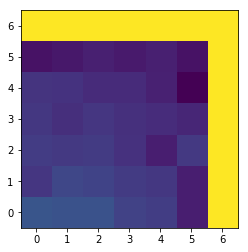

In [667]:
plt.imshow(dsperc_mar, origin='lower', vmax=-50)

In [668]:
ds_mar_dic = {
    'data' : dsperc_mar,
    'ybins' : qbinsb_march,
    'xbins' : shearb_march,
    'title' : 'March observed',
    'valid' : dsval_mar,
    'cbarlabel' : '10th centile Tmin',
    'vmin' : -73, #np.percentile(dsperc_mar[dsperc_mar!=0],1),
    'vmax' : -68, #np.percentile(dsperc_mar[dsperc_mar!=0],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}

ds_oct_dic = {
    'data' : dsperc_oct,
    'ybins' : qbinsb_oct,
    'xbins' : shearb_oct,
    'title' : 'October observed',
    'valid' : dsval_oct,
    'cbarlabel' : '10th centile Tmin',
    'vmin' : -69,
    'vmax' : -64,
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}

In [669]:
cp4_mar_dic = {
    'data' : cp4perc_mar,
    'ybins' : qbinsc_march,
    'xbins' : shearc_march,
    'title' : 'March CP4',
    'valid' : cp4val_mar,
    'cbarlabel' : '10th centile Tmin',
    'vmin' : -67, #np.percentile(cp4perc_mar[(cp4perc_mar!=0) & np.isfinite(cp4perc_mar) ],1),
    'vmax' : -63, #np.percentile(cp4perc_mar[(cp4perc_mar!=0) & np.isfinite(cp4perc_mar)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}

cp4_oct_dic = {
    'data' : cp4perc_oct,
    'ybins' : qbinsc_oct,
    'xbins' : shearc_oct,
    'title' : 'October CP4',
    'valid' : cp4val_oct,
    'cbarlabel' : '10th centile Tmin',
    'vmin' : -66, #np.percentile(cp4perc_oct[(cp4perc_oct!=0) & np.isfinite(cp4perc_oct)],1),
    'vmax' : -62, #np.percentile(cp4perc_oct[(cp4perc_oct!=0) & np.isfinite(cp4perc_oct)],99),
    'ylabel' : 'Max. q925hPa',
    'xlabel' : 'Max. 650-925hPa shear'
}

(array([ 11.,  36.,  89., 194., 379., 660., 690., 691., 518., 198.]),
 array([-70.46432092, -68.45856406, -66.4528072 , -64.44705034,
        -62.44129348, -60.43553662, -58.42977975, -56.42402289,
        -54.41826603, -52.41250917, -50.40675231]),
 <a list of 10 Patch objects>)

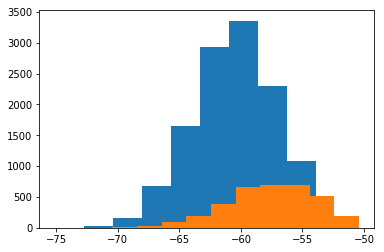

In [670]:
plt.hist(ds_oct.tmean)
plt.hist(cp4_oct.tmean)

In [671]:
data_list = [ds_mar_dic, ds_oct_dic, cp4_mar_dic, cp4_oct_dic]

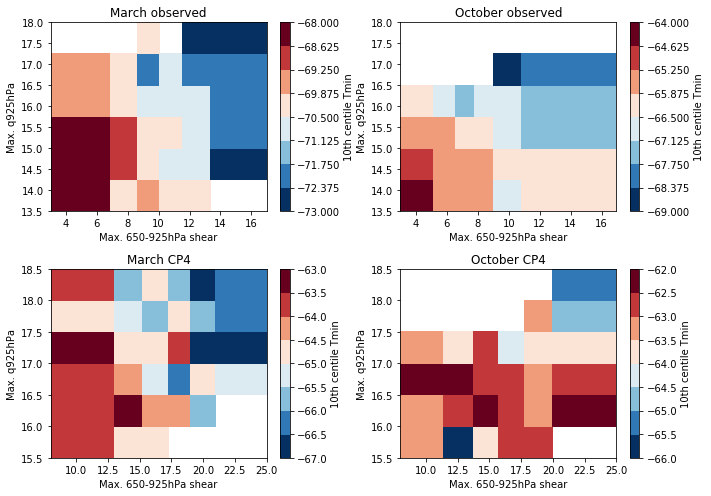

In [672]:
hist2d_quatro(data_list, valid=True)

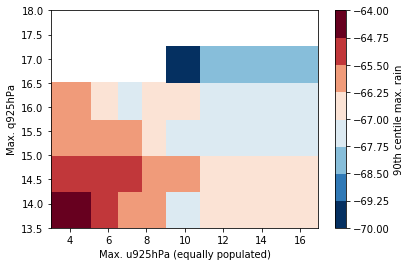

In [616]:
hist2d_plot(dsperc_oct, shearb_oct, qbinsb_oct, vmin=-70, vmax=-64)